In [1]:
from qsweepy import *
from qsweepy.instruments import *
from qsweepy.ponyfiles import *
from matplotlib.pyplot import *
from numpy import *
from matplotlib import interactive
import time
import pickle
import datetime
interactive(True)
import scipy.optimize as so
import jpa_tuning
import imp

Failed loading module Keysight_M3102A:  No module named 'keysightSD1'
Failed loading module Keysight_M3202A:  No module named 'keysightSD1'
[WinError 126] The specified module could not be found
Failed loading module Signal_Hound_SA:  name 'signal_hound_dll' is not defined


In [131]:
imp.reload(jpa_tuning)

<module 'jpa_tuning' from 'D:\\qtlab_replacement\\notebooks\\Abramov\\jpa_tuning.py'>

In [3]:
timestamp = lambda:datetime.datetime.fromtimestamp(time.time()).strftime('%d-%m_%H_%M_%S')

In [2]:
savepath = "D:\\Abramov\\SNAIL_data"

In [ ]:
db = database.MyDatabase()
sweeper = sweep_extras.Sweeper(db, sample_name="SNAIL")

In [4]:
pna = Agilent_N5242A('pna', address = 'TCPIP0::10.20.61.48::inst0::INSTR')
pump = Agilent_E8257D('pump', address = 'TCPIP0::10.20.61.59::inst0::INSTR')
bias = Yokogawa_GS210(address = 'GPIB1::1::INSTR')

# Manual 

In [413]:
pna.get_all()

{'nop': 2000,
 'power': -40.0,
 'start freq': 6000000000.0,
 'stop freq': 8500000000.0,
 'span': 2500000000.0,
 'bw': 100.0,
 'sweep mode': 'LIN\n'}

In [411]:
pna.set_xlim(6e9, 8.5e9)

In [ ]:
pna.set_centerfreq(13.6e9/2)

In [77]:
pna.set_frequency(7.9e9+1e6)

True

In [405]:
pna.set_sweep_mode('lin')

True

In [406]:
pna.set_nop(2000)

True

In [407]:
pna.set_bandwidth(100)

True

In [412]:
pna.set_power(-40)

True

In [346]:
pump.get_all()

{'status': False, 'freq': 15900000000.0, 'power': 15.4}

In [415]:
pump.set_status(0)

True

In [78]:
pump.set_frequency(7.9e9*2)

True

In [53]:
pump.set_power(-7.5)

True

In [ ]:
pump.set_phase(-1.5)

In [345]:
bias.get_status()

1

In [ ]:
bias.set_current(-0.003457000000000058 )

# Network analyzer snapshot

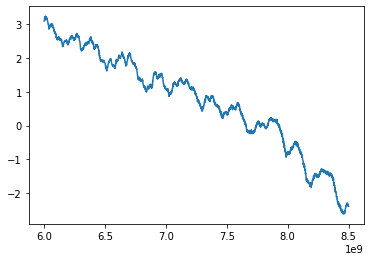

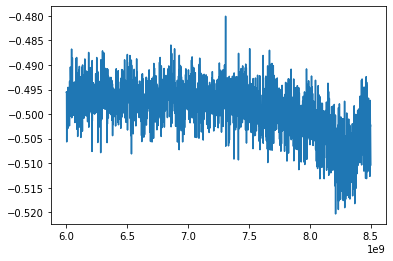

In [417]:
save_data = True
pna.set_sweep_mode('lin')
F = pna.get_freqpoints()
data = pna.get_tracedata(format = 'REALIMAG')
S21 = data[0]+1.j*data[1]
figure("mag")
plot(F, 20*log10(abs(S21)))
figure("delay")
plot(F[1:], diff( unwrap(angle(S21)) ) )
if save_data:
    filename = "S21vsF"
    ts = timestamp()
    full_path = savepath+"\\"+ts+"_"+filename
    savefig(full_path+".png", dpi = 300)
    f = open(full_path+".pkl", 'wb')
    pickle.dump({'S21':S21, 'F':F, "Power":pna.get_power(), "Bandwidth":pna.get_bandwidth()} , f)
    f.close()
#xlim((6.95e9,7.05e9))

In [ ]:
S21_ref = S21

# Network analyzer CW snapshot

In [59]:
f_cw = 7.25e9-2e6
filename = 'snr'

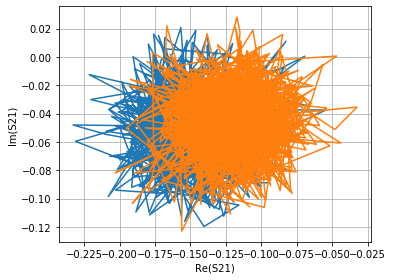

In [81]:
pump.set_status(1)
pna.set_sweep_mode('cw')
pna.set_frequency(f_cw)
pna.set_nop(1000)
pna.set_bandwidth(100e3)
pna.pre_sweep()
data = pna.get_tracedata(format = 'REALIMAG')
swe_time = pna.get_sweep_time()
S21_on = data[0]+1.j*data[1]
plot(S21_on.real, S21_on.imag)
pump.set_status(0)
time.sleep(0.1)
data = pna.get_tracedata(format = 'REALIMAG')
pna.post_sweep()
S21_off = data[0]+1.j*data[1]
plot(S21_off.real, S21_off.imag)
grid()
gca().set_aspect('equal')
pump.set_status(1)
xlabel("Re(S21)")
ylabel("Im(S21)")
tight_layout()
ts = timestamp()
full_path = savepath+"\\"+ts+"_"+filename
savefig(full_path+".png", dpi = 300)
f = open(full_path+".pkl", 'wb')
pickle.dump({'S21_on':S21_on, 'S21_on':S21_off, "time": swe_time, "Power":pna.get_power(), "Bandwidth":pna.get_bandwidth()} , f)
f.close()

In [82]:
snr_off= abs(mean(S21_off))/std(S21_off) 
snr_on = abs(mean(S21_on))/std(S21_on) 
snr_on/snr_off

1.1954629344624295

In [ ]:
f = open(savepath+'\\7GHz_S21.pkl', 'wb')
pickle.dump({'S21_on':S21_on, 'S21_on':S21_off, "time": swe_time, "Power":pna.get_power(), "Bandwidth":pna.get_bandwidth()} , f)
f.close()

In [ ]:
mean(20*log10(abs(S21_on)))

# S21 pump phase dependavce

In [ ]:
save_data =False
phases = linspace(-pi,pi,200)
pna.set_sweep_mode('cw')
pna.set_frequency(f_cw)
pna.set_nop(1)
pna.set_bandwidth(100)

S21 = array([],dtype = complex)
for ph in phases:
    pump.set_phase(ph)
    data = pna.get_tracedata(format = 'REALIMAG')
    S21 = hstack([S21,data[0]+1.j*data[1]])
plot(phases, 20*log10(abs(S21)))
if save_data:
    filename = "S21vsPhase"
    ts = timestamp()
    full_path = savepath+"\\"+ts+"_"+filename
    savefig(full_path+".png", dpi = 300)
    f = open(full_path+".pkl", 'wb')
    pickle.dump({'S21':S21, "Phase":phases ,'F':f_cw, "Power":pna.get_power(), "Bandwidth":pna.get_bandwidth()} , f)
    f.close()

# Gain compression

In [ ]:
detuning = 1e6
pna.set_sweep_mode('cw')
pna.set_frequency(f_cw+detuning )
pna.set_nop(1)
pna.set_bandwidth(100)

powers = arange(-70,-5,1)
ref_p = -50
ref_bw = 100
min_bw= 1

def set_power(p):
    pna.set_power(p)
    bw = 10**((p - ref_p)/10)*ref_bw 
    if bw<min_bw:
        bw = min_bw
    pna.set_bandwidth( bw ) 
    time.sleep(0.1)
result = sweeper.sweep(pna, (powers, set_power, 'Power'), measurement_type = "gain_compression")

In [ ]:
plot(result.datasets['S-parameter'].parameters[0].values, 20*log10(abs(result.datasets['S-parameter'].data)))


## Gain compression with tuning table

In [428]:
tt = jpa_tuning.TuningTable()
tt.load(savepath+"\\TuningTables\\10db.txt")

In [429]:
detuning = 1e6
pna.set_sweep_mode('cw')
pna.set_nop(1)
pna.set_bandwidth(100)

pump.set_status(1)
bias.set_status(1)

powers = arange(-70,1,1)
point_ind = range(len(tt.I))
ref_p = -50
ref_bw = 100
min_bw= 1

def set_power(p):
    if p == powers[-1]:
        pna.set_power(-30)
        pna.set_bandwidth( 100 )
        pump.set_status(0)
        time.sleep(0.05)
    else:    
        pna.set_power(p)
        bw = 10**((p - ref_p)/10)*ref_bw 
        if bw<min_bw:
            bw = min_bw
        pna.set_bandwidth( bw ) 
        time.sleep(0.1)

def set_op(i):
    op = tt.ind(i)
    bias.set_current(op.I)
    pna.set_frequency(op.Fp/2.+detuning)
    pump.set_frequency(op.Fp)
    pump.set_power(op.Pp)
    pump.set_status(1)
    time.sleep(0.05)
    
result = sweeper.sweep(pna, (point_ind, set_op, 'Operating point'), (powers, set_power, 'Power'), 
                       measurement_type = "gain_compression",
                      metadata = tt.to_dict() )

S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-pa

S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-pa

S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
load time:  0.05096912384033203
pre_trace_time:  0.0019979476928710938
trace 0 time:  0.030980348587036133
trace 1 time:  0.06396055221557617
trace 2 time:  0.09494209289550781
trace 3 time:  0.12992072105407715


In [ ]:
op = tt.ind(4)
tuner.set_op(op)

pna.set_sweep_mode('lin')
pna.set_centerfreq( op.Fp/2 )
pna.set_nop(600)
pna.set_bandwidth(1000)

pump.set_status(1)
powers = arange(-70,-5,1)
ref_p = -50
ref_bw = 1000
min_bw= 1

def set_power(p):
    pna.set_power(p)
    bw = 10**((p - ref_p)/10)*ref_bw 
    if bw<min_bw:
        bw = min_bw
    pna.set_bandwidth( bw ) 
    time.sleep(0.1)
result = sweeper.sweep(pna, (powers, set_power, 'Power'), measurement_type = "gain_compression",
                      metadata = {'G':op.G,'Fp':op.Fp, 'Pp':op.Pp,'I':op.I} )

# Resonator mapping

In [353]:
currents = arange(-7,7.05,0.05)*1e-3
result = sweeper.sweep(pna, (currents, bias.set_current, 'Current'), measurement_type = "resonator_mapping")

S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-parameter
S-pa

# Tuning

In [418]:
imp.reload(jpa_tuning)

<module 'jpa_tuning' from 'D:\\qtlab_replacement\\notebooks\\Abramov\\jpa_tuning.py'>

In [419]:
tuner = jpa_tuning.JpaTuner(vna = pna, pump = pump, bias = bias)

In [420]:
tuner.I0 = 0.
tuner.I05 = -4e-3
tuner.Pp_init = 5.
tuner.Ps = -60.
tuner.Pp_max = 17.
tuner.Gthr = 5.

In [397]:
op, status = tuner.find_gain_sm(20, 8.2e9)

Refrence measurement...
S21_ref = -1.42 dB
Raw search...
Raw search: P = 11.00 dBm I= -9.4000e-04A G = 5.03 dBB
Noise measurement...
G = 1.80 Sigma= 5.357715e-02
Max search: I= -1.0790e-03A G = 4.44 dB Gmax = 5.49 dB
Power optimization:P = 15.80 dBm G = 1.54 Gmax = 15.388
Itune I = -1.4920e-03A P = 15.74dBm G = 2.93dB
Itune I = -1.1160e-03A P = 15.74dBm G = 3.05dB


In [391]:
tt.add_point(op)

In [392]:
tt.dump(savepath+"\\20db.txt") 

In [421]:
target_gains = [10,15,25]
for target_gain in target_gains:
    tt = jpa_tuning.TuningTable()
    for Fs in arange(6.5e9, 8.2e9, 0.05e9):
        print(Fs*1e-9)
        op,status = tuner.find_gain_sm(target_gain , Fs)
        if status:
            tt.add_point(op)
            tt.dump(savepath+"\\{:.0f}db.txt".format(target_gain)) 

6.5
Refrence measurement...
S21_ref = 1.80 dB
Raw search...
6.5500000000000017.00 dBm I= -3.9800e-03A G = 0.31 dBB
Refrence measurement...
S21_ref = 1.70 dB
Raw search...
6.6000000000000005.00 dBm I= -3.9800e-03A G = 1.36 dBB
Refrence measurement...
S21_ref = 1.71 dB
Raw search...
6.65search: P = 17.00 dBm I= -3.9800e-03A G = 2.12 dBB
Refrence measurement...
S21_ref = 1.68 dB
Raw search...
Raw search: P = 12.00 dBm I= -2.0600e-03A G = 5.11 dBB
Noise measurement...
G = 1.77 Sigma= 3.929855e-02
Max search: I= -2.1980e-03A G = 4.50 dB Gmax = 5.32 dB
Power optimization:P = 13.56 dBm G = 3.93 Gmax = 5.53
Itune I = -2.3040e-03A P = 12.67dBm G = 3.70dB
Itune I = -1.5600e-03A P = 12.67dBm G = 4.32dB
Power optimization:P = 13.81 dBm G = 5.44 Gmax = 6.86
Itune I = -2.0020e-03A P = 13.40dBm G = 5.26dB
Itune I = -1.4580e-03A P = 13.40dBm G = 6.46dB
Power optimization:P = 13.90 dBm G = 9.57 Gmax = 9.57
Itune I = -1.6390e-03A P = 13.90dBm G = 8.37dB
Itune I = -1.3340e-03A P = 13.90dBm G = 8.96dB
6.7

Raw search: P = 5.00 dBm I= -2.3600e-03A G = 5.18 dBB
Noise measurement...
G = 1.83 Sigma= 4.353251e-02
Max search: I= -2.6140e-03A G = 7.15 dB Gmax = 7.88 dB
Power optimization:P = 7.50 dBm G = 14.77 Gmax = 14.77
Itune I = -2.6070e-03A P = 7.50dBm G = 14.15dB
Itune I = -2.4950e-03A P = 7.50dBm G = 14.36dB
7.1000000000000005
Refrence measurement...
S21_ref = 0.67 dB
Raw search...
Raw search: P = 6.00 dBm I= -2.4000e-03A G = 5.31 dBB
Noise measurement...
G = 1.89 Sigma= 4.365198e-02
Max search: I= -2.5480e-03A G = 5.72 dB Gmax = 6.47 dB
Power optimization:P = 9.44 dBm G = 14.82 Gmax = 14.82
Itune I = -2.5200e-03A P = 9.44dBm G = 14.37dB
Itune I = -2.4420e-03A P = 9.44dBm G = 14.44dB
7.15
Refrence measurement...
S21_ref = 0.67 dB
Raw search...
Raw search: P = 5.00 dBm I= -2.2600e-03A G = 5.33 dB
Noise measurement...
G = 1.84 Sigma= 4.256192e-02
Max search: I= -2.4860e-03A G = 7.04 dB Gmax = 7.68 dB
Power optimization:P = 7.68 dBm G = 14.84 Gmax = 14.84
Itune I = -2.4840e-03A P = 7.68dBm 

Itune I = -2.4010e-03A P = 10.82dBm G = 24.85dB
Itune I = -2.3700e-03A P = 10.75dBm G = 24.86dB
7.250000000000001
Refrence measurement...
S21_ref = 0.43 dB
Raw search...
Raw search: P = 5.00 dBm I= -2.2000e-03A G = 5.06 dBB
Noise measurement...
G = 1.78 Sigma= 4.082414e-02
Max search: I= -2.3900e-03A G = 5.47 dB Gmax = 6.20 dB
Power optimization:P = 9.75 dBm G = 24.94 Gmax = 24.94
Itune I = -2.3240e-03A P = 9.75dBm G = 24.82dB
Itune I = -2.3210e-03A P = 9.75dBm G = 24.80dB
7.300000000000001
Refrence measurement...
S21_ref = -0.08 dB
Raw search...
Raw search: P = 5.00 dBm I= -2.0400e-03A G = 5.20 dB
Noise measurement...
G = 1.81 Sigma= 5.234132e-02
Max search: I= -2.2940e-03A G = 7.38 dB Gmax = 8.14 dB
Power optimization:P = 8.60 dBm G = 25.17 Gmax = 25.17
Itune I = -2.2460e-03A P = 8.59dBm G = 24.53dB
Itune I = -2.2010e-03A P = 8.57dBm G = 24.70dB
7.3500000000000005
Refrence measurement...
S21_ref = 0.24 dB
Raw search...
Raw search: P = 6.00 dBm I= -2.0800e-03A G = 5.39 dBB
Noise measu

In [361]:
status

True

In [33]:
op,status = tuner.find_gain(20. , 6.9e9)

Refrence measurement...
S21_ref = 1.39 dB
Raw search...
I= -1.4300e-03A G = 20.45 dB
Noise measurement...
G = 10.64 Sigma= 1.380806e-01
Fine search...
I = -2.0370e-03A P = 13.34dBm G = 19.46dB


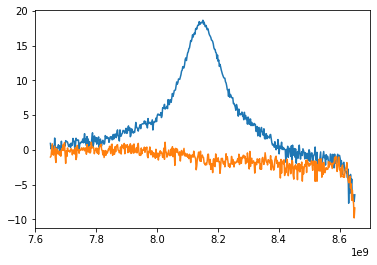

In [390]:
S21on, S21off, F  = tuner.vna_snapshot( op, 1e9, bw = 500,Ps = -60)
plot(F, 20*log10(abs(S21on)))
plot(F, 20*log10(abs(S21off)))

In [267]:
op.Pp = 13

## Save em all

In [434]:
tt = jpa_tuning.TuningTable()
tt.load(savepath+"\\TuningTables\\10db.txt")

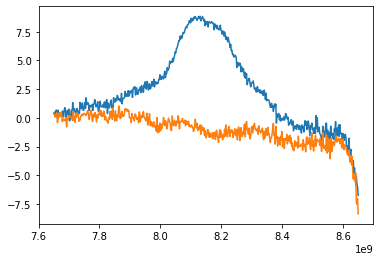

In [435]:
for i,op in enumerate(tt):
    S21on, S21off, F  = tuner.vna_snapshot( op, 1e9, bw = 400, Ps = -55)
    clf()
    plot(F, 20*log10(abs(S21on)))
    plot(F, 20*log10(abs(S21off)))
    
    filename = "{:d}".format(i)
    full_path = savepath+"\\10db\\"+filename
    
    savefig(full_path+".png", dpi = 300)
    
    f = open(full_path+".pkl", 'wb')
    pickle.dump({'S21on':S21on,'S21off':S21off,  'F':F, } , f)
    f.close()

In [ ]:
tt.dump(savepath+"\\table.txt")

In [ ]:
tt.load(savepath+"\\table.txt")

In [ ]:
tt.I

In [252]:
figure('test')
Plist = arange(12,13,1)
Ilist = arange(0.,-4.5e-3, -0.02e-3)
gain = zeros( [len(Plist), len(Ilist)] )
for i, P in enumerate(Plist):
    #pump.set_power(P)
    for j,I in enumerate(Ilist):
        bias.set_current(I)
        time.sleep(0.05)
        print('{:.2f} {:e}'.format(P,I), end = '\r')
        gain[i][j] = abs(tuner.meas_S21()[0])    

<Figure size 432x288 with 0 Axes>

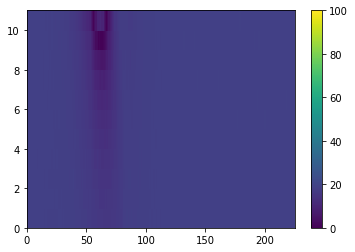

In [123]:
pcolormesh( sqrt((gain-20)**2) )
colorbar()
clim([0,100])

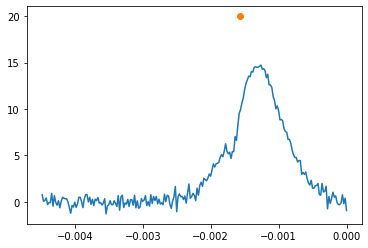

In [253]:
for g in gain:
    plot(Ilist,log10(g)*20)
    plot(op.I, 20,'o')

In [179]:
op.I

-0.002632000000000007